<a href="https://colab.research.google.com/github/Shin-kyoto/www/blob/develop2/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# nltkの文章群にscikit-learnを用いてクラスタリングを適用してみる

## 導入編

### 必要なライブラリ・データセットのインポート

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import collections

### 今回は以下のnltkの機能を使用できる様にする


In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("reuters")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### データを取得

In [ ]:
from nltk.corpus import reuters as corpus

### datasetの中身を確認

In [ ]:
for n,item in enumerate(corpus.words(corpus.fileids()[0])[:300]):
    print(item, end=" ")
    if (n%25) ==24:
      print(" ")

ASIAN EXPORTERS FEAR DAMAGE FROM U . S .- JAPAN RIFT Mounting trade friction between the U . S . And Japan has raised fears  
among many of Asia ' s exporting nations that the row could inflict far - reaching economic damage , businessmen and officials said . They  
told Reuter correspondents in Asian capitals a U . S . Move against Japan might boost protectionist sentiment in the U . S . And  
lead to curbs on American imports of their products . But some exporters said that while the conflict would hurt them in the long -  
run , in the short - term Tokyo ' s loss might be their gain . The U . S . Has said it will  
impose 300 mln dlrs of tariffs on imports of Japanese electronics goods on April 17 , in retaliation for Japan ' s alleged failure to  
stick to a pact not to sell semiconductors on world markets at below cost . Unofficial Japanese estimates put the impact of the tariffs at  
10 billion dlrs and spokesmen for major electronics firms said they would virtually halt exports 

### 全document数

In [ ]:
len(corpus.fileids())

10788

### (例) 前からk個のdocumentのみで学習する場合

In [ ]:
k = 100
docs=[corpus.words(fileid) for fileid in corpus.fileids()[:k]]

### 全documentで学習する場合

In [ ]:
#docs=[corpus.words(fileid) for fileid in corpus.fileids()]

print(docs[:5])
print("num of docs:", len(docs))

[['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', ...], ['CHINA', 'DAILY', 'SAYS', 'VERMIN', 'EAT', '7', '-', ...], ['JAPAN', 'TO', 'REVISE', 'LONG', '-', 'TERM', ...], ['THAI', 'TRADE', 'DEFICIT', 'WIDENS', 'IN', 'FIRST', ...], ['INDONESIA', 'SEES', 'CPO', 'PRICE', 'RISING', ...]]
num of docs: 100


## 前処理編

### 例 : ストップワードリストの作成

### nltkのストップワードリスト

In [ ]:
en_stop = nltk.corpus.stopwords.words('english')

### 例:【発展】記号や数字は正規表現で消してみる

In [ ]:
en_stop= ["``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<"]                  \
         +["0","1","2","3","4","5","6","7","8","9","10","11","12","86","1986","1987","000"]                                                      \
         +["said","say","u","v","mln","ct","net","dlrs","tonne","pct","shr","nil","company","lt","share","year","billion","price"]          \
         +en_stop

### 前処理関数の作成

In [ ]:
from nltk.corpus import wordnet as wn #lemmatize関数のためのimport

def preprocess_word(word, stopwordset):
    
    #1.make words lower ex: Python =>python
    word=word.lower()
    
    #2.remove "," and "."
    if word in [",","."]:
        return None
    
    #3.remove stopword  ex: the => (None) 
    if word in stopwordset:
        return None
    
    #4.lemmatize  ex: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word

    elif lemma in stopwordset: #lemmatizeしたものがstopwordである可能性がある
        return None
    else:
        return lemma
    

def preprocess_document(document):
    document=[preprocess_word(w, en_stop) for w in document]
    document=[w for w in document if w is not None]
    return document

def preprocess_documents(documents):
    return [preprocess_document(document) for document in documents]

### 前処理の結果を出力してみる

### 前処理前

In [ ]:
print(docs[0][:25]) 

['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', '.', 'S', '.-', 'JAPAN', 'RIFT', 'Mounting', 'trade', 'friction', 'between', 'the', 'U', '.', 'S', '.', 'And', 'Japan', 'has', 'raised', 'fears']


### 前処理後

In [ ]:
print(preprocess_documents(docs)[0][:25])

['asian', 'exporter', 'fear', 'damage', 'japan', 'rift', 'mounting', 'trade', 'friction', 'japan', 'raise', 'fear', 'among', 'many', 'asia', 'exporting', 'nation', 'row', 'could', 'inflict', 'far', 'reaching', 'economic', 'damage', 'businessmen']


## クラスタリング編

### tf idfで上記の前処理済みの文章をベクトル化
### vectorizerを使用する（ハイパーパラメーターの設定）

In [ ]:
pre_docs=preprocess_documents(docs)
pre_docs=[" ".join(doc) for doc in pre_docs]
print(pre_docs[0])

vectorizer = TfidfVectorizer(max_features=200, token_pattern=u'(?u)\\b\\w+\\b' )

asian exporter fear damage japan rift mounting trade friction japan raise fear among many asia exporting nation row could inflict far reaching economic damage businessmen official tell reuter correspondent asian capital move japan might boost protectionist sentiment lead curb american import product exporter conflict would hurt long run short term tokyo loss might gain impose 300 tariff import japanese electronics good april 17 retaliation japan allege failure stick pact sell semiconductor world market cost unofficial japanese estimate put impact tariff spokesman major electronics firm would virtually halt export product hit new tax able business spokesman leading japanese electronics firm matsushita electric industrial co ltd mc >. tariff remain place length time beyond month mean complete erosion export good subject tariff tom murtha stock analyst tokyo office broker james capel co >. taiwan businessmen official also worry aware seriousness threat japan serve warning us senior taiwan

### fitする

In [ ]:
tf_idf = vectorizer.fit_transform(pre_docs)

### K-means
### kmeansの設定

In [ ]:
num_clusters = 8
km = KMeans(n_clusters=num_clusters, random_state = 0)

### fitする

In [ ]:
clusters = km.fit_predict(tf_idf)

### 出力結果

In [ ]:
for doc, cls in zip(pre_docs, clusters):
    print(cls,doc)

2 asian exporter fear damage japan rift mounting trade friction japan raise fear among many asia exporting nation row could inflict far reaching economic damage businessmen official tell reuter correspondent asian capital move japan might boost protectionist sentiment lead curb american import product exporter conflict would hurt long run short term tokyo loss might gain impose 300 tariff import japanese electronics good april 17 retaliation japan allege failure stick pact sell semiconductor world market cost unofficial japanese estimate put impact tariff spokesman major electronics firm would virtually halt export product hit new tax able business spokesman leading japanese electronics firm matsushita electric industrial co ltd mc >. tariff remain place length time beyond month mean complete erosion export good subject tariff tom murtha stock analyst tokyo office broker james capel co >. taiwan businessmen official also worry aware seriousness threat japan serve warning us senior taiw

## ヒント

<p1>
scikit-learnのvectorizerとkmeansにはたくさんのハイパーパラメータがあります。vectorizerのハイパーパラメータの中には前処理機能(例：stop_words)もあります。
    ハイパーパラメータの設定を変える事で最終的な結果は変わります。以下のURLにアクセスしてハイパーパラメータの独自で設定してみてください。<br>
    ・TF-IDFに関するパラメータ<br>
    https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html<br>
    ・Kmeansに関するパラメータ<br>
    https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html<br>
</p1>


## 応用
<p1>
    クラスタリング編でコードを以下に指示に従って変更する事で結果がどの様に変わるのかを確認してみましょう<br>
    （１）講義で学んだ他の手法でベクトル化してみる(例：bag-of-words)<br>
    （２）kmeans以外の手法、又はkmeansを可視化してみる(例：階層型クラスタリング)<br>
<p1>

##1. SVD
SVDでの可視化はあまりうまくいかなかった

In [ ]:
# 次元圧縮（特異値分解）クラス初期化
lsa = TruncatedSVD(2)
# サンプルデータ、及びクラスタ中心点のベクトル情報を2次元に圧縮
compressed_text_list = lsa.fit_transform(tf_idf)
compressed_center_list = lsa.fit_transform(km.cluster_centers_)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.font_manager as fm


NUM_CLUSTER=num_clusters

def draw_km(text_list, km_text_labels,
            compressed_center_list, compressed_text_list):

    # 描画開始。
    fig = plt.figure()
    axes = fig.add_subplot(111)
    for label in range(NUM_CLUSTER):

        # ラベルごとに色を分ける。
        # 色はカラーマップ（cool）におまかせする。
        color = cm.cool(float(label) / NUM_CLUSTER)

        # ラベルの中心をプロット
        xc, yc = compressed_center_list[label]
        axes.plot(xc, yc,
                  color=color,
                  ms=6.0, zorder=3, marker="o")

        # クラスタのラベルもプロット
        axes.annotate(
            label, xy=(xc, yc))
        
        
        for text_num, text_label in enumerate(km_text_labels):

            if text_label == label:
                # labelが一致するテキストをプロット
                x, y = compressed_text_list[text_num]
                axes.plot(x, y,
                          color=color,
                          ms=5.0, zorder=2, marker="x")

                # テキストもプロット
                #axes.annotate(
                    #text_list[text_num], xy=(x, y))

                # ラベルの中心点からの線をプロット
                axes.plot([x, xc], [y, yc],
                          color=color,
                          linewidth=0.5, zorder=1, linestyle="--")
        

    plt.axis('tight')
    plt.show()

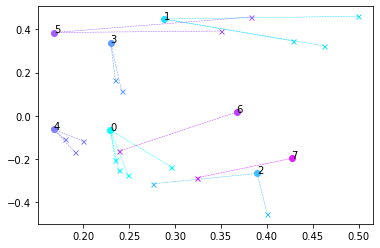

In [ ]:
 draw_km(pre_docs, km.labels_,
            compressed_center_list, compressed_text_list)

##2. t-SNEで次元降下

In [ ]:
from sklearn.manifold import TSNE
tfidf2d = TSNE(n_components=2).fit_transform(tf_idf)

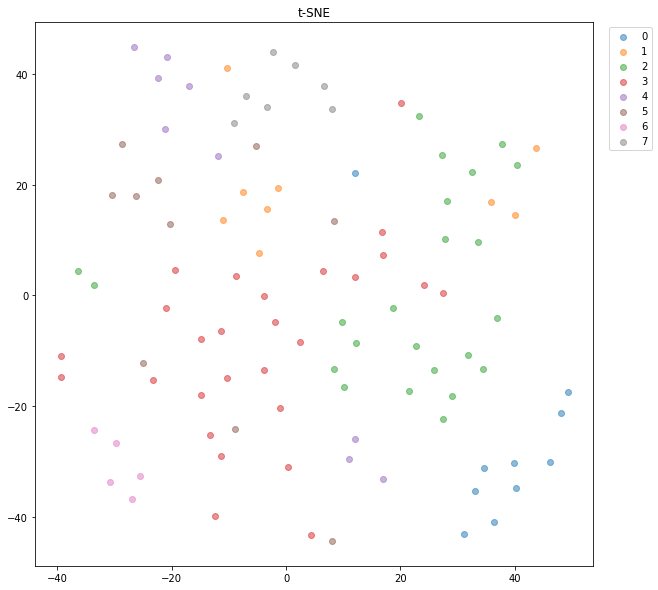

In [ ]:
from matplotlib import pylab as plt

f, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in range(8):
    target = tfidf2d[clusters == i]
    ax.scatter(x=target[:, 0], y=target[:, 1], label=str(i), alpha=0.5)
plt.title('t-SNE')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

###1. クラスタ内残差平方和(SSE)を計算

In [ ]:
#k=8の時の
km.inertia_

73.11743512932676

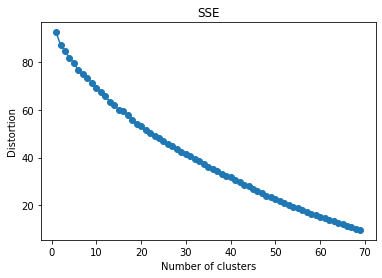

In [ ]:
distortions = []

for i  in range(1,70):                # 1~70クラスタまで一気に計算 
    km = KMeans(n_clusters=i,random_state=0)
    km.fit(tf_idf)                         # クラスタリングの計算を実行
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.plot(range(1,70),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('SSE')
plt.show()

In [ ]:
tf_idf.shape

(100, 200)

##2. シルエット分析を行う．
シルエット図をk=4, 5, 6,7,8,10,12,15,20,30,50に対し出力し，シルエット分析を行った．

- シルエット図：各データごとにシルエット係数を算出し，クラスタごとに棒グラフにして出力した図
- 凝集度：データが属しているクラスタ内のその他すべてのサンプルとの平均距離
- 乖離度：データが属していないクラスタの中で最も近くにあるクラスタ内のすべてのサンプルとの平均距離
- シルエット係数：各クラスタごとの乖離度から凝集度を引いた値を正規化（凝集度，乖離度のうち大きい方で割った）値

- クラスターの「シルエット係数 silhouette coefficient 」が 1に近いほど、そのクラスターは他のクラスターから遠く離れていることを表す（係数は -1 ~ 1の間をとる）

- 0に近いほど隣接するクラスターと接近している or 隣接するクラスターと重なっていることを表す（上手くクラスターの分離ができていない状態）.
係数がマイナス値だとクラスター化されたサンプルは間違ったクラスターに所属している可能性がある
シルエットの"厚さ thickness"はクラスターのサイズ（所属するサンプル数）を表す

- 適切にクラスター分離できていれば各クラスターのシルエットの"厚さ"は均等に近くなるらしい

For n_clusters = 4 The average silhouette_score is : 0.052951608104851625


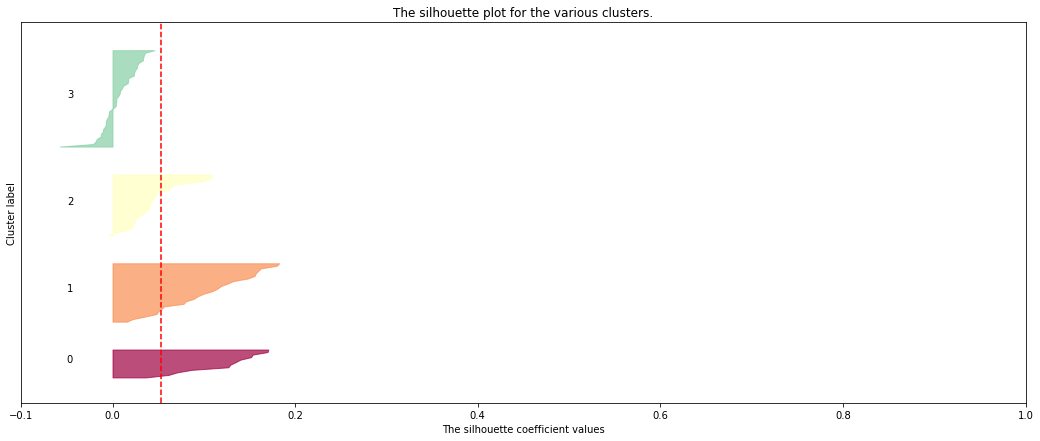

For n_clusters = 5 The average silhouette_score is : 0.059261744475318706


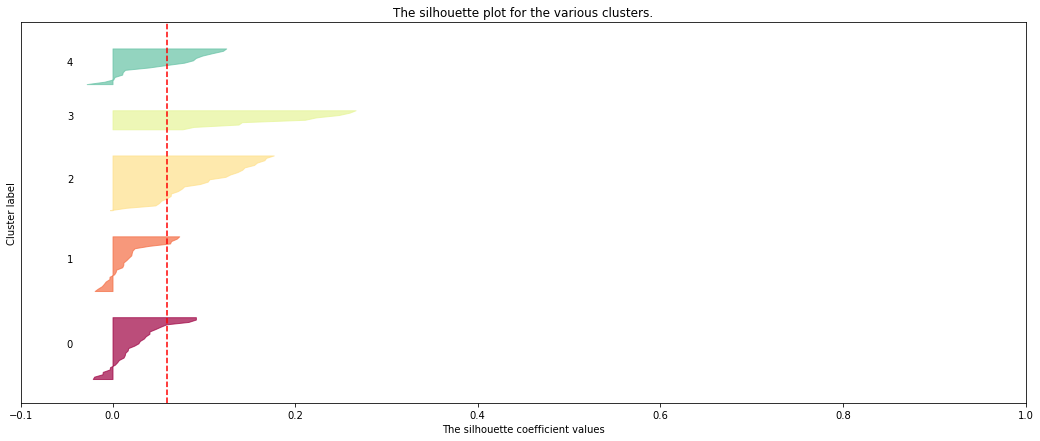

For n_clusters = 6 The average silhouette_score is : 0.07188145408114063


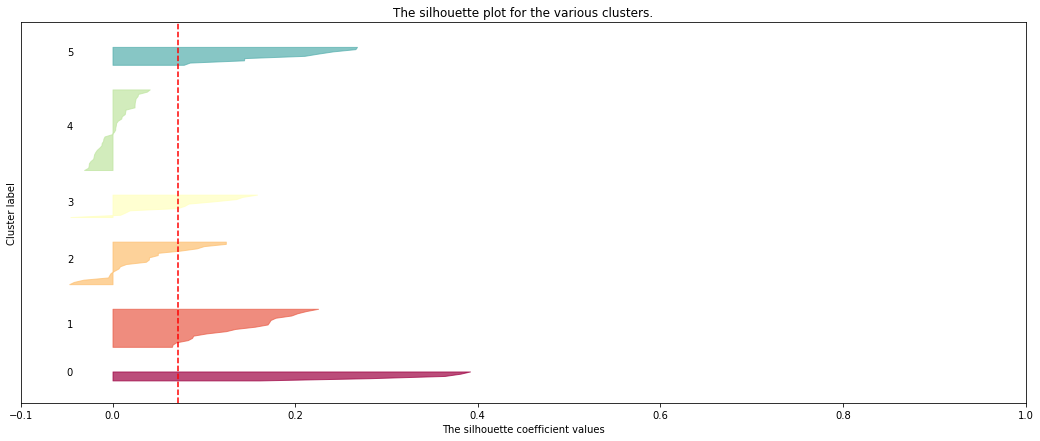

For n_clusters = 7 The average silhouette_score is : 0.07317614300114031


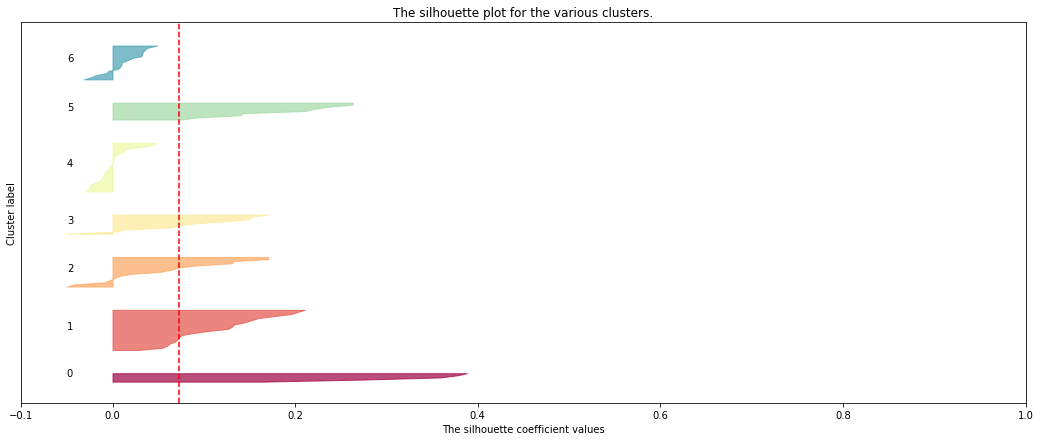

For n_clusters = 8 The average silhouette_score is : 0.07750338616611409


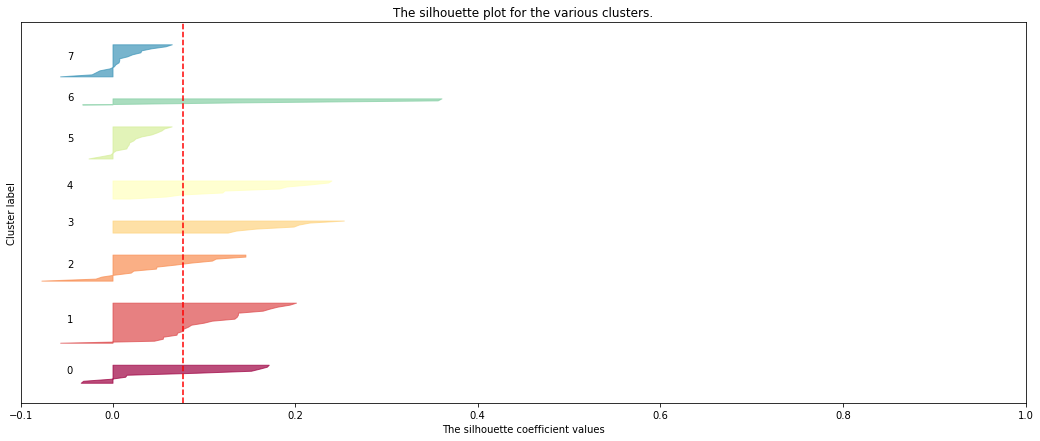

For n_clusters = 10 The average silhouette_score is : 0.080785292999073


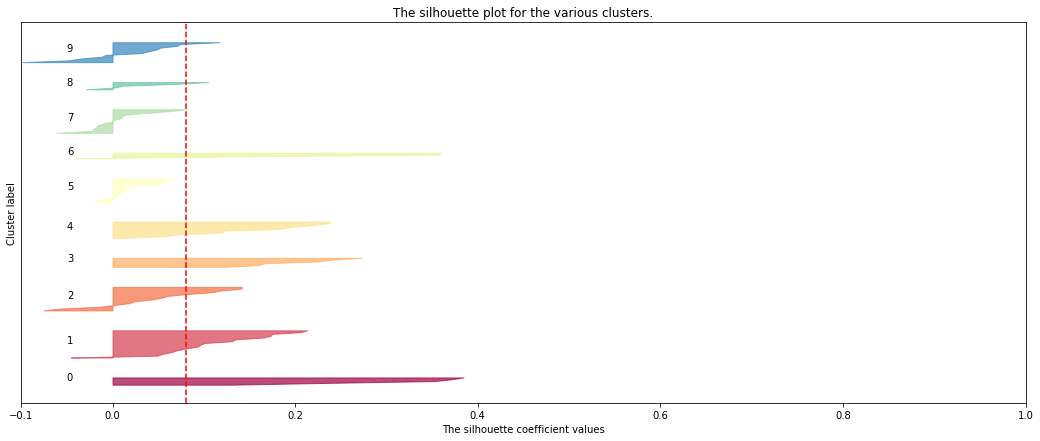

For n_clusters = 12 The average silhouette_score is : 0.08447742368214356


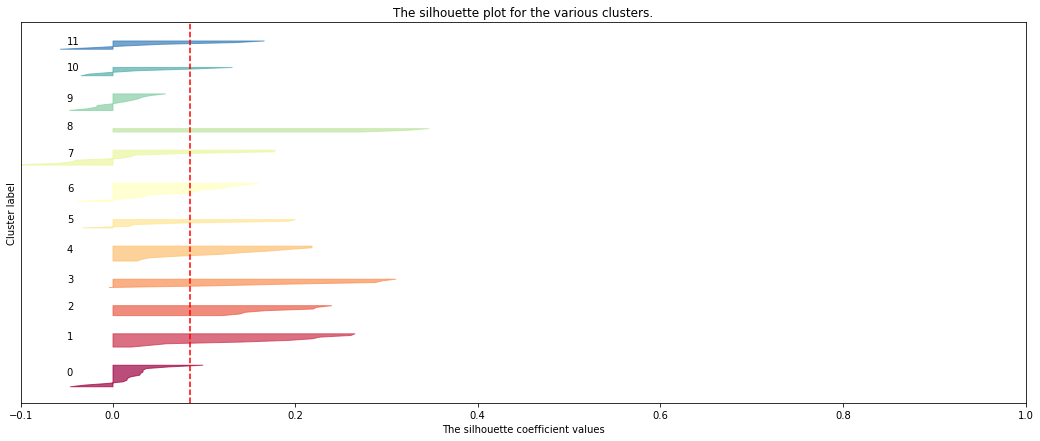

For n_clusters = 15 The average silhouette_score is : 0.10268675142168714


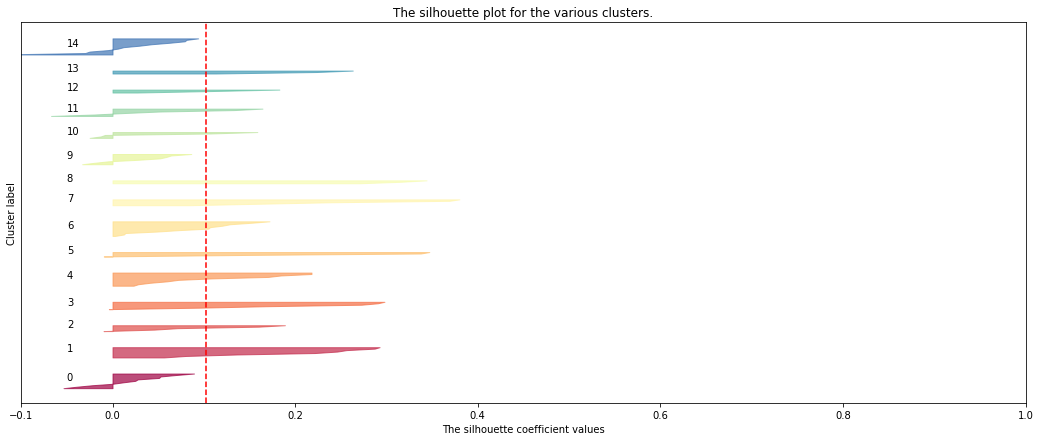

For n_clusters = 20 The average silhouette_score is : 0.12212759453741942


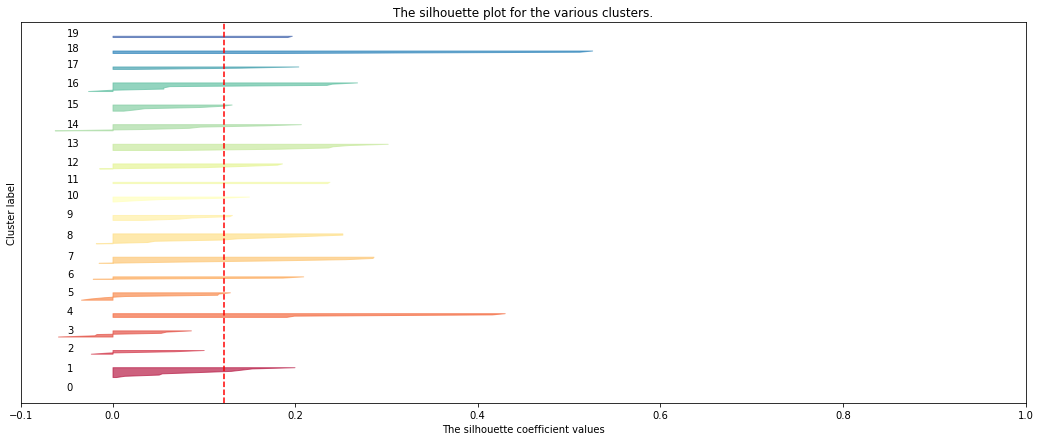

For n_clusters = 30 The average silhouette_score is : 0.14956616884044385


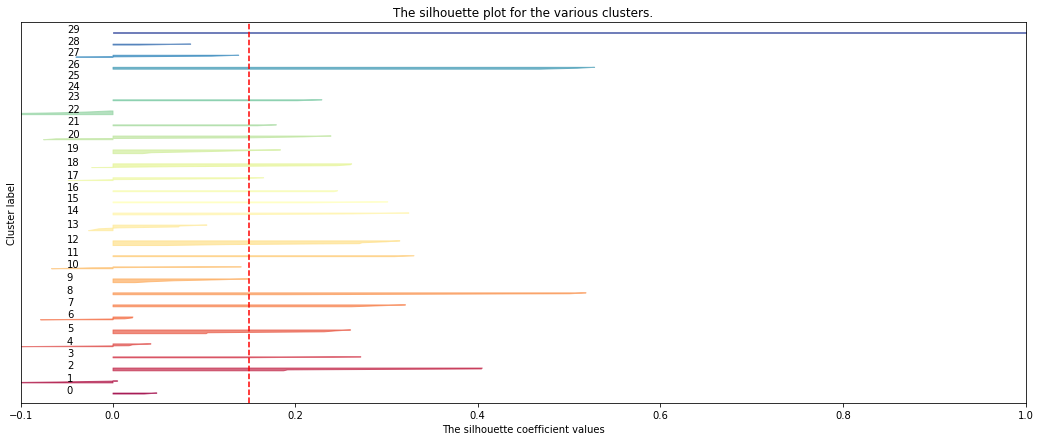

For n_clusters = 50 The average silhouette_score is : 0.16646789201329756


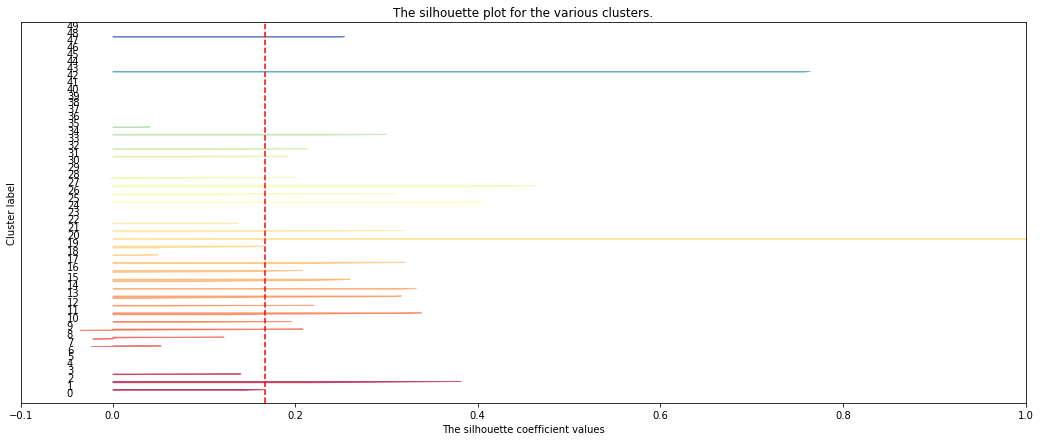

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
range_n_clusters = [4, 5, 6,7,8,10,12,15,20,30,50]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, tf_idf.shape[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(tf_idf)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(tf_idf, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(tf_idf, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)

        #color = cm.spectral()
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    

    plt.show()